In [1]:
%matplotlib inline
from itertools import product as c_product
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model

from disp import set_font_size
from lin_fit import fit_h


EXPT = 'CL_360_LOWFLOW_ACV'
EXPT = 'CL_180_HighFlow_ACV'

TARGS = ['G2', 'G3', 'G4', 'G5']
SRCS = ['Odor', 'AbsHeading', 'ForVel']
NORMED_COLS = ['G2', 'G3', 'G4', 'G5', 'ForVel', 'AngVel', 'AbsAngVel', 'Heading', 'AbsHeading']

T_WDW = [-4.5, 4.5]  # must be symmetric to ensure correct convolution
TRUNCATE = 5  # num timepoints to truncate for edge effects

T_WDW_OTA = [-10., 10.]  # time window for odor-triggered avg
VARS_OTA = [
    'G2', 'G3', 'G4', 'G5',
    'DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5',
    'AbsHeading', 'DeltaAbsHeading',
    'ForVel', 'DeltaForVel'
]

DT = 0.1
T_WDW_TR = [DT * (int(T_WDW[0]/DT) + TRUNCATE), DT * (int(T_WDW[1]/DT) - TRUNCATE)]

DATA_DIR = os.path.join('data', EXPT)
SAVE_DIR = os.path.join('data_', '_RESULTS', 'ODOR_TRACKING')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

# Load data and normalize

In [2]:
base = 'clean.csv'
mvng = 'moving.csv'
mvng_cols = ['Start', 'Stop']
odor = 'odor_times.csv'
odor_cols = ['Odor_On', 'Odor_Off', 'Include']

data_u = {}  # unnormalized data
data_n = {}  # normalized data
d_mvng = {}  # dfs of moving times
d_odor = {}  # dfs of odor times

for fly in os.listdir(DATA_DIR):
    fly_path = os.path.join(DATA_DIR, fly)
    
    for trial in os.listdir(fly_path):
        trial_path = os.path.join(fly_path, trial)
        
        # load data
        data_u_ = pd.read_csv(os.path.join(trial_path, base))
        
        # store relevant columns
        data_u_ = data_u_[['Time', 'G2_avg', 'G3_avg', 'G4_avg', 'G5_avg', 'ForVel', 'AngVel', 'Heading']]
        data_u_['AbsAngVel'] = np.abs(data_u_['AngVel'])
        data_u_['AbsHeading'] = np.abs(data_u_['Heading'])
        
        # make odor mask
        df_odor = pd.read_csv(os.path.join(trial_path, odor))
        odor_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_odor[odor_cols[0]]
        stops = df_odor[odor_cols[1]]
        
        for start, stop in zip(starts, stops):
            odor_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Odor'] = odor_mask.astype(float)
        
        # make moving mask
        df_mvng = pd.read_csv(os.path.join(trial_path, mvng))
        mvng_mask = np.zeros(len(data_u_['Time']), dtype=bool)
        starts = df_mvng[mvng_cols[0]]
        stops = df_mvng[mvng_cols[1]]
        
        for start, stop in zip(starts, stops):
            mvng_mask[(start <= data_u_['Time']) & (data_u_['Time'] < stop)] = True
            
        data_u_['Mvng'] = mvng_mask
        
        data_u_ = data_u_.rename(columns={'G2_avg': 'G2', 'G3_avg': 'G3', 'G4_avg': 'G4', 'G5_avg': 'G5'})
        
        # normalize data
        data_n_ = data_u_.copy()
        data_n_[NORMED_COLS] -= data_n_[NORMED_COLS].mean()
        data_n_[NORMED_COLS] /= data_n_[NORMED_COLS].std()
        
        # store all results
        data_u[trial] = data_u_
        data_n[trial] = data_n_
        d_mvng[trial] = df_mvng
        d_odor[trial] = df_odor

# Trial-by-trial odor and heading filters

## Fit filters

In [3]:
mode = 'FULL'

# create initial filter dataframes
t_h = np.arange(*T_WDW, DT)
df_blank = pd.DataFrame(
    np.nan, index=sorted(list(data_n)),
    columns=(['N', 'R2'] + list(t_h[TRUNCATE:-TRUNCATE]))).rename_axis('TRIAL')

filters = {'{}_FROM_{}'.format(targ, src.upper()): df_blank.copy() for targ, src in c_product(TARGS, SRCS)}

# set up discrete windows over which to define filter
wdws_d = [None, None]
wdws_d[0] = int(round(T_WDW[0]/DT))
wdws_d[1] = wdws_d[0] + int(len(t_h))

# loop over trials
for trial, data_n_ in data_n.items():
    
    # loop over srcs & targs
    for src in SRCS:
        for targ in TARGS:
            # compute filter
            xs = {src: np.array(data_n_[src])}
            y = np.array(data_n_[targ])
            
            hs, icpt, y_hat, r2 = fit_h(
                xs, y, {src: wdws_d}, [src], 'built-in', params={'model': linear_model.LinearRegression})
            
            n = np.sum(~np.isnan(y_hat))
            
            # store filter
            filters['{}_FROM_{}'.format(targ, src.upper())].loc[trial] = [n, r2] + list(hs[src][TRUNCATE:-TRUNCATE])

# save all filters
for k, df_save in filters.items():
    fn = 'FILTERS_{}_{}_T_WDW_{}_{}_{}.csv'.format(EXPT, k, *T_WDW_TR, mode)
    df_save.to_csv(os.path.join(SAVE_DIR, fn), na_rep='NaN')

## Plot filters

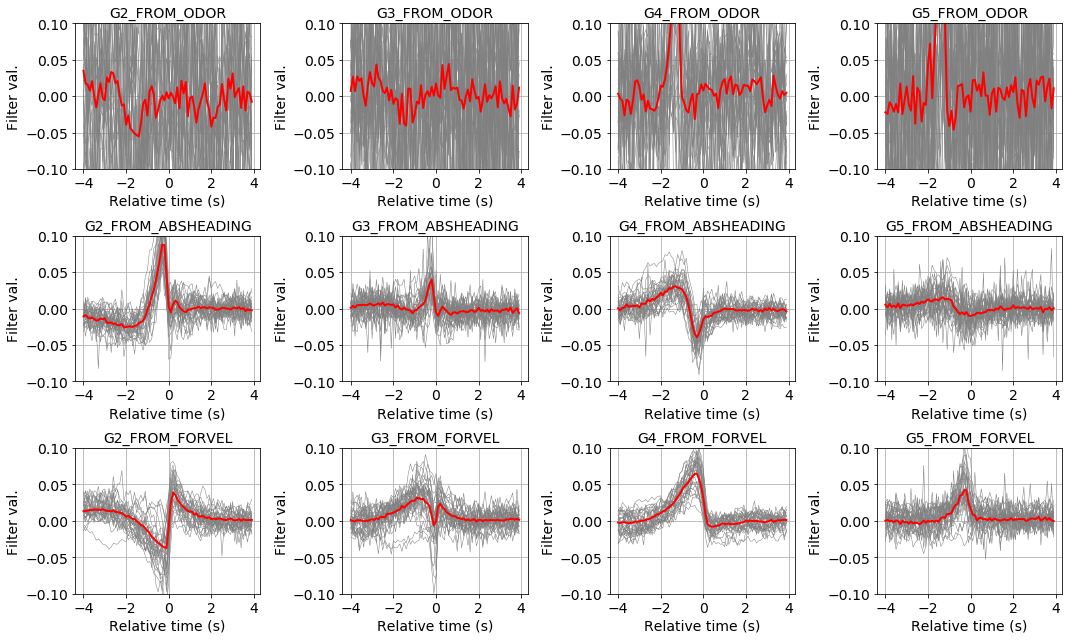

In [4]:
mode = 'FULL'

# plot filters
y_lim = (-.1, .1)
n_xmpls = 30

fig, axs = plt.subplots(len(SRCS), len(TARGS), figsize=(15, 3*len(SRCS)), tight_layout=True)

for src, ax_row in zip(SRCS, axs):
    for targ, ax in zip(TARGS, ax_row):
        k = '{}_FROM_{}'.format(targ, src.upper())
        
        fn = 'FILTERS_{}_{}_T_WDW_{}_{}_{}.csv'.format(EXPT, k, *T_WDW_TR, mode)
        
        df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
        
        # random trials
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.sample(n_xmpls)).T[2:], lw=0.5, color='gray')
        
        # mean
        ax.plot(t_h[TRUNCATE:-TRUNCATE], np.array(df.mean())[2:], lw=2, color='r')
        
        ax.set_ylim(y_lim)
        
        ax.set_xlabel('Relative time (s)')
        ax.set_ylabel('Filter val.')
        ax.set_title(k)
        
        ax.grid()
        set_font_size(ax, 14)
        
fig.savefig(os.path.join(SAVE_DIR, 'FILTERS_{}_T_WDW_{}_{}_{}.pdf'.format(EXPT, *T_WDW_TR, mode)))

# Odor-triggered DANs, ForVel, Heading

In [5]:
t_ota = np.arange(*T_WDW_OTA, DT)
wdw_d = [None, None]
wdw_d[0] = int(round(T_WDW_OTA[0]/DT))
wdw_d[1] = wdw_d[0] + len(t_ota)

df_blank = pd.DataFrame(columns=['PulseID', 'Trial', 'PulseCounter', 'Include'] + list(t_ota))

odor_trig = {k.upper(): df_blank.copy() for k in VARS_OTA}

# VARS_OTA = [
#     'G2', 'G3', 'G4', 'G5',
#     'DFF0G2', 'DFF0G3', 'DFF0G4', 'DFF0G5',
#     'AbsHeading', 'DeltaAbsHeading',
#     'ForVel', 'DeltaForVel'
# ]

# loop over trials
p_id = 0

for trial, data_u_ in data_u.items():
    # loop over odor pulses
    pulses = d_odor[trial]
    
    starts = pulses[odor_cols[0]]
    stops = pulses[odor_cols[1]]
    includes_binary = pulses[odor_cols[2]]
    includes = ['Include' if x else 'Exclude' for x in includes_binary ]
    
    for ctr, (start, stop, include) in enumerate(zip(starts, stops, includes)):
        # get time window for data selection
        t_idx = int(round(start/DT))
        t_idx_0 = t_idx + wdw_d[0]
        t_idx_1 = t_idx + wdw_d[1]
        
        g2 = data_u_['G2'][t_idx_0:t_idx_1]
        g3 = data_u_['G3'][t_idx_0:t_idx_1]
        g4 = data_u_['G4'][t_idx_0:t_idx_1]
        g5 = data_u_['G5'][t_idx_0:t_idx_1]
        
        for_vel = data_u_['ForVel'][t_idx_0:t_idx_1]
        abs_heading = data_u_['AbsHeading'][t_idx_0:t_idx_1]
        
        odor_trig['G2'].loc[p_id] = [p_id, trial, ctr, include] + list(g2)
        odor_trig['G3'].loc[p_id] = [p_id, trial, ctr, include] + list(g3)
        odor_trig['G4'].loc[p_id] = [p_id, trial, ctr, include] + list(g4)
        odor_trig['G5'].loc[p_id] = [p_id, trial, ctr, include] + list(g5)
        
        odor_trig['FORVEL'].loc[p_id] = [p_id, trial, ctr, include] + list(for_vel)
        odor_trig['ABSHEADING'].loc[p_id] = [p_id, trial, ctr, include] + list(abs_heading)
        
        # get computed data features
        
        ## neural dff/f
        f0_g2 = np.nanmean(g2[t_ota < 0])
        f0_g3 = np.nanmean(g3[t_ota < 0])
        f0_g4 = np.nanmean(g4[t_ota < 0])
        f0_g5 = np.nanmean(g5[t_ota < 0])
        
        dff_g2 = (g2 - f0_g2) / f0_g2
        dff_g3 = (g3 - f0_g3) / f0_g3
        dff_g4 = (g4 - f0_g4) / f0_g4
        dff_g5 = (g5 - f0_g5) / f0_g5
        
        odor_trig['DFF0G2'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g2)
        odor_trig['DFF0G3'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g3)
        odor_trig['DFF0G4'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g4)
        odor_trig['DFF0G5'].loc[p_id] = [p_id, trial, ctr, include] + list(dff_g5)
        
        ## behavior delta
        for_vel_0 = np.nanmean(for_vel[t_ota < 0])
        abs_heading_0 = np.nanmean(abs_heading[t_ota < 0])
        
        delta_for_vel = for_vel - for_vel_0
        delta_abs_heading = abs_heading - abs_heading_0
        
        odor_trig['DELTAFORVEL'].loc[p_id] = [p_id, trial, ctr, include] + list(delta_for_vel)
        odor_trig['DELTAABSHEADING'].loc[p_id] = [p_id, trial, ctr, include] + list(delta_abs_heading)
        
        p_id += 1
        
# save results
for k, df_save in odor_trig.items():
    fn = 'ODOR_TRIG_{}.csv'.format(k)
    df_save.to_csv(os.path.join(SAVE_DIR, fn), na_rep='NaN', index=False)

## Plot odor-triggered DANs

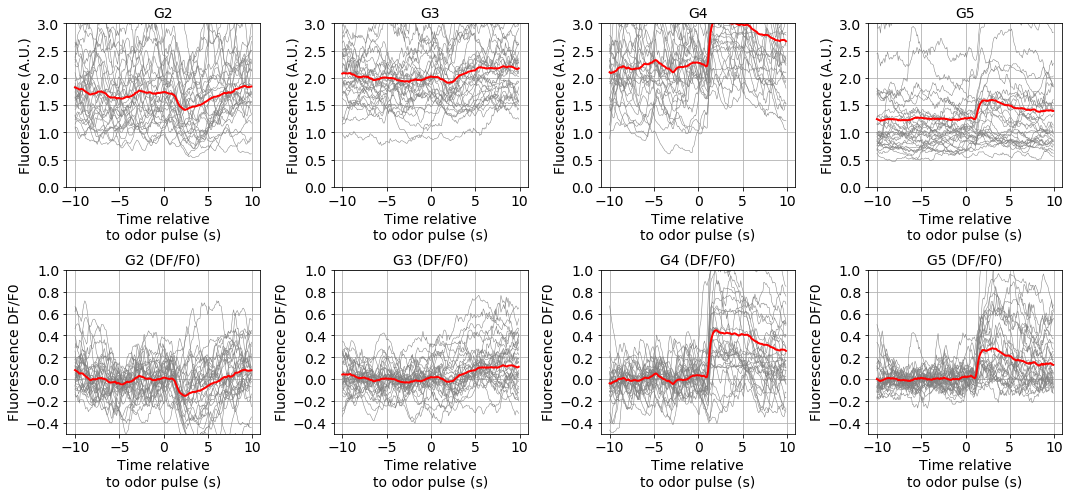

In [6]:
t_ota = np.arange(*T_WDW_OTA, DT)
n_xmpls = 30
y_lims = [(0, 3), (-.5, 1)]

fig, axs = plt.subplots(2, 4, figsize=(15, 7), tight_layout=True)

for ax_col, gx in zip(axs.T, ['G2', 'G3', 'G4', 'G5']):

    # original DAN
    ## open file
    fn = 'ODOR_TRIG_{}.csv'.format(gx)
    df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)

    ## random trials
    ax_col[0].plot(t_ota, np.array(df.sample(n_xmpls)).T[3:], lw=0.5, color='gray')

    ## mean
    ax_col[0].plot(t_ota, np.array(df.mean())[1:], lw=2, color='r')
    
    ax_col[0].set_ylim(y_lims[0])
    
    ax_col[0].set_xlabel('Time relative\nto odor pulse (s)')
    ax_col[0].set_ylabel('Fluorescence (A.U.)')
    ax_col[0].set_title(gx)
    
    # DF/F0 DANs
    fn = 'ODOR_TRIG_DFF0{}.csv'.format(gx)
    df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
    
    ## random trials
    ax_col[1].plot(t_ota, np.array(df.sample(n_xmpls)).T[3:], lw=0.5, color='gray')

    ## mean
    ax_col[1].plot(t_ota, np.array(df.mean())[1:], lw=2, color='r')
    
    ax_col[1].set_ylim(y_lims[1])
    
    ax_col[1].set_xlabel('Time relative\nto odor pulse (s)')
    ax_col[1].set_ylabel('Fluorescence DF/F0')
    ax_col[1].set_title('{} (DF/F0)'.format(gx))
    
for ax in axs.flat:
    ax.grid()
    set_font_size(ax, 14)

## Plot odor-triggered ForVel and AbsHeading

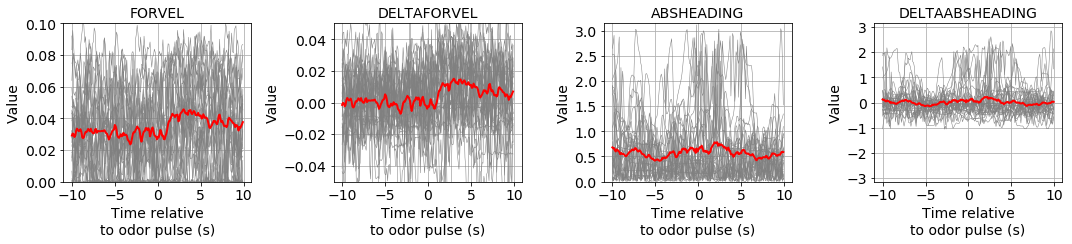

In [10]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3.5), tight_layout=True)
y_lims = [(0, .1), (-.05, .05), (0, 3.14159), (-3.14159, 3.14159)]

sfxs = ['FORVEL', 'DELTAFORVEL', 'ABSHEADING', 'DELTAABSHEADING']

for ax, sfx, y_lim in zip(axs, sfxs, y_lims):
    
    # load data
    fn = 'ODOR_TRIG_{}.csv'.format(sfx)
    df = pd.read_csv(os.path.join(SAVE_DIR, fn), index_col=0)
    
    # random trials
    ax.plot(t_ota, np.array(df.sample(n_xmpls)).T[3:], lw=0.5, color='gray')
    
    # mean
    ax.plot(t_ota, np.array(df.mean())[1:], lw=2, color='r')
    
    ax.set_ylim(y_lim)
    
    ax.set_xlabel('Time relative\nto odor pulse (s)')
    ax.set_ylabel('Value')
    
    ax.set_title(sfx)
    
for ax in axs:
    ax.grid()
    set_font_size(ax, 14)

# Odor-triggered DANs

# Odor-masked/unmasked DAN-from-AbsHeading filters

# Time-varying correlation of odor-triggered G4 and heading

# Table of odor-triggered metrics

# Nested model analysis on odor-triggered metrics